In [2]:
import numpy as np # import for math and array operations
import pandas as pd # import for dataframe handle
import matplotlib.pyplot as plt # import for visual representation
import seaborn as sns # import for visual representation
import math
from bs4 import BeautifulSoup
import requests
import datetime as dt

%load_ext autoreload
%autoreload 2

In [3]:
df = pd.read_csv('../raw_data/steam_games.csv')

# Cleaning columns

### URL

### Types

In [5]:
new_df = df.copy().dropna(subset=['types'])
app_df = new_df[new_df['types'] == 'app']

### Names

### Desc_snippet

In [6]:
# Complete desc_snippet with game_description
for index in app_df['desc_snippet'].index:
    app_df.loc[index, 'desc_snippet'] = app_df.loc[index, 'game_description']

### Reviews

In [7]:
def clean_review(review):
    if '%' in str(review):
        return review.split(',')[0]
    else:
        return float('nan')

In [8]:
app_df['clean_reviews']=app_df['all_reviews'].apply(clean_review)

/var/folders/dv/7t_6tkbx07s6mfq_r5jxkp240000gp/T/ipykernel_38301/3993235492.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_df['clean_reviews']=app_df['all_reviews'].apply(clean_review)


### Dates

In [9]:
def convert_date(date):
    try:
        return dt.datetime.strptime(date, "%b %d, %Y")
    except:
        return date
    
def valid_date(date):
    if isinstance(date, dt.datetime):
        return True
    else:
        return False

In [10]:
app_df['release_date'] = app_df['release_date'].apply(convert_date)

/var/folders/dv/7t_6tkbx07s6mfq_r5jxkp240000gp/T/ipykernel_38301/3659942068.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_df['release_date'] = app_df['release_date'].apply(convert_date)


In [11]:
# add a validate column
app_df['valid_date'] = app_df['release_date'].apply(valid_date)

/var/folders/dv/7t_6tkbx07s6mfq_r5jxkp240000gp/T/ipykernel_38301/1590340263.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_df['valid_date'] = app_df['release_date'].apply(valid_date)


### Developer

### Publisher

In [12]:
### Publisher cleaning sub
def clean_pub(x):
    if ',' in str(x):
        if x.split(',')[0] == x.split(',')[1]:
            return x.split(',')[0] 

app_df['publisher'] = app_df['publisher'].apply(lambda x : clean_pub(x))

/var/folders/dv/7t_6tkbx07s6mfq_r5jxkp240000gp/T/ipykernel_38301/3629656861.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_df['publisher'] = app_df['publisher'].apply(lambda x : clean_pub(x))


In [13]:
#### Replacing missing publisher by developer - add inplace = True
app_df.publisher = app_df.publisher.fillna(app_df.developer)

/var/folders/dv/7t_6tkbx07s6mfq_r5jxkp240000gp/T/ipykernel_38301/1628064062.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_df.publisher = app_df.publisher.fillna(app_df.developer)


### Popular tags

In [14]:
### creating a loop of all the different tags, calculating the occurences to select the top used.
tags = {}
for index, row in app_df.iterrows():
    tags_list= str(row['popular_tags']).split(',')
    for tag in tags_list:
        if not tag in tags:
            tags[tag] = 1
        else:
            tags[tag] += 1
            
            
tags_df = pd.DataFrame(list(tags.items()),columns = ['tag','count'])
tags_df.sort_values('count', ascending =False)

,tag,count
50,Indie,23718
2,Action,16112
42,Adventure,13378
75,Casual,12969
31,Simulation,9273
...,...,...
369,Snowboarding,3
364,BMX,3
362,ATV,3
202,Asymmetric VR,3


### Languages

In [15]:
### creating a loop of all the different languages, calculating the occurences to select the top used.
languages = {}
for index, row in app_df.iterrows():
    languages_list= str(row['languages']).split(',')
    for language in languages_list:
        if not language in languages:
            languages[language] = 1
        else:
            languages[language] += 1

languages_df = pd.DataFrame(list(languages.items()),columns = ['language','count'])
languages_df.sort_values('count', ascending =False)

,language,count
0,English,38007
3,German,13050
1,French,12512
4,Spanish - Spain,11554
8,Russian,9716
2,Italian,9620
5,Japanese,8693
11,Simplified Chinese,7116
7,Portuguese - Brazil,5326
6,Polish,4935


### Game details

In [16]:
### creating a loop of all the different details, calculating the occurences to select the top used.
details = {}
# Stripping game details
df.game_details = app_df.game_details.str.strip()
for index, row in app_df.iterrows():
    details_list= str(row['game_details']).split(',')
    for detail in details_list:
        if not detail in details:
            details[detail] = 1
        else:
            details[detail] += 1

details_df = pd.DataFrame(list(details.items()),columns = ['game_details','count'])
details_df.sort_values('count', ascending =False)

,game_details,count
0,Single-player,33797
3,Steam Achievements,19891
29,Downloadable Content,13169
6,Steam Cloud,11770
4,Steam Trading Cards,11587
14,Full controller support,8975
24,Profile Features Limited \r\n\t\t\t\t\t\t\t\t\t,8443
1,Multi-player,8386
5,Partial Controller Support,7081
17,Steam Leaderboards,6142


### Achievements

In [17]:
#categorization - adding a column for achievement cat
for i in app_df.index:
    app_df.at[i, 'achievement_cat'] = 0 if math.isnan(app_df.loc[i]['achievements']) == True else 1

/var/folders/dv/7t_6tkbx07s6mfq_r5jxkp240000gp/T/ipykernel_38301/1847830268.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_df.at[i, 'achievement_cat'] = 0 if math.isnan(app_df.loc[i]['achievements']) == True else 1


### Genre

In [19]:
genre_dict = {}
for index, row in app_df.iterrows():
    genre_list= str(row['genre']).split(',')
    for genre in genre_list:
        if not genre in genre_dict:
            genre_dict[genre] = 1
        else:
            genre_dict[genre] += 1
genre_df = pd.DataFrame(list(genre_dict.items()),columns = ['genre','count'])
genre_df.sort_values('count', ascending =False) 

,genre,count
6,Indie,22868
0,Action,15265
10,Casual,12010
1,Adventure,11871
8,Simulation,8711
3,Strategy,7975
5,RPG,6962
7,Early Access,2818
4,Free to Play,2620
11,Sports,1725


### Game Desc

In [20]:
app_df['game_description']=app_df['game_description'].astype(str)

/var/folders/dv/7t_6tkbx07s6mfq_r5jxkp240000gp/T/ipykernel_38301/1020820551.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_df['game_description']=app_df['game_description'].astype(str)


In [22]:
app_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38021 entries, 0 to 40832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   url                       38021 non-null  object 
 1   types                     38021 non-null  object 
 2   name                      38007 non-null  object 
 3   desc_snippet              37920 non-null  object 
 4   recent_reviews            2706 non-null   object 
 5   all_reviews               28470 non-null  object 
 6   release_date              37654 non-null  object 
 7   developer                 37721 non-null  object 
 8   publisher                 37779 non-null  object 
 9   popular_tags              37888 non-null  object 
 10  game_details              37546 non-null  object 
 11  languages                 38007 non-null  object 
 12  achievements              12194 non-null  float64
 13  genre                     37625 non-null  object 
 14  game_d

### Mature Content

In [23]:
app_df=app_df.assign(mature_encoded=lambda x: x.mature_content.isna().replace((True,False),(0,1)))

### Prices

In [24]:
app_df=app_df.assign(price=lambda x: pd.to_numeric(x.original_price.str.strip('$'), errors='coerce').replace(np.nan, 0))

# Cleaning columns

In [25]:
clean_df = app_df.drop(['mature_content', 'achievements', 'recent_reviews', 'desc_snippet', 'original_price', 'discount_price'], axis = 1)

In [26]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38021 entries, 0 to 40832
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   url                       38021 non-null  object 
 1   types                     38021 non-null  object 
 2   name                      38007 non-null  object 
 3   all_reviews               28470 non-null  object 
 4   release_date              37654 non-null  object 
 5   developer                 37721 non-null  object 
 6   publisher                 37779 non-null  object 
 7   popular_tags              37888 non-null  object 
 8   game_details              37546 non-null  object 
 9   languages                 38007 non-null  object 
 10  genre                     37625 non-null  object 
 11  game_description          38021 non-null  object 
 12  minimum_requirements      21069 non-null  object 
 13  recommended_requirements  21075 non-null  object 
 14  clean_

In [27]:
clean_df[clean_df['clean_reviews'].isnull() == True]['clean_reviews']

40       NaN
59       NaN
90       NaN
152      NaN
180      NaN
        ... 
40828    NaN
40829    NaN
40830    NaN
40831    NaN
40832    NaN
Name: clean_reviews, Length: 20658, dtype: object

# Scraping Columns

### Names

In [70]:
def get_name(url):
    response = requests.get(url).text
    soup = BeautifulSoup(response, "html.parser")
    try: 
        return soup.find('h2', class_='pageheader').text.strip()
    except AttributeError:
        try:
            return soup.find('div', class_='apphub_AppName').text.strip()
        except AttributeError:
            return float('nan')

In [71]:
for index in clean_df[clean_df['name'].isnull()].index:
    clean_df.loc[index, 'name'] = get_name(clean_df.loc[index, 'url'])

In [73]:
clean_df[clean_df['name'].isnull()== True]

,url,types,name,desc_snippet,recent_reviews,all_reviews,release_date,developer,publisher,popular_tags,...,game_description,mature_content,minimum_requirements,recommended_requirements,original_price,discount_price,valid_date,achievement_cat,mature_encoded,price
6381,https://store.steampowered.com/bundle/7125/Fac...,app,NaN,About this bundle This bundle contains thre...,NaN,NaN,NaN,NaN,NaN,NaN,...,About this bundle This bundle contains thre...,NaN,NaN,NaN,NaN,$2.67,False,0.0,0,0.0
12146,https://store.steampowered.com/bundle/10912/Th...,app,NaN,About this bundle All Joe Papp content.,NaN,NaN,NaN,NaN,NaN,NaN,...,About this bundle All Joe Papp content.,NaN,NaN,NaN,NaN,$9.96,False,0.0,0,0.0
28380,https://store.steampowered.com/bundle/10417/Ha...,app,NaN,About this bundle Purchase this bundle to sa...,NaN,NaN,NaN,NaN,NaN,NaN,...,About this bundle Purchase this bundle to sa...,NaN,NaN,NaN,NaN,$16.55,False,0.0,0,0.0
31321,https://store.steampowered.com/app/976190/_/,app,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Action,Indie,Third-Person Shooter,Retro",...,nan,NaN,NaN,NaN,NaN,NaN,False,0.0,0,0.0


### Reviews

In [ ]:
def get_review(url):
    response = requests.get(url).text
    soup = BeautifulSoup(response, "html.parser")
    try: 
        return soup.find('span', class_='game_review_summary').text.strip()
    except AttributeError:
        return float('nan')

In [ ]:
for index in app_df[app_df['all_reviews'].isnull()].index:
    app_df.loc[index, 'all_reviews'] = get_review(app_df.loc[index, 'url'])

### Dates

In [12]:
def get_date(url):
    response = requests.get(url).text
    soup = BeautifulSoup(response, "html.parser")
    try: 
        return soup.find('div', class_='date').text.strip()
    except AttributeError:
        return float('nan')

In [ ]:
for index in app_df[app_df['release_date'].isnull()].index:
    app_df.loc[index, 'release_date'] = get_date(app_df.loc[index, 'url'])

### Developer

In [ ]:
def get_dev(url):
    response = requests.get(url).text
    soup = BeautifulSoup(response, "html.parser")
    try: 
        return soup.find('div', id='developers_list').text.strip().split(',')[0]
    except:
        return float('nan')

In [ ]:
temp = df_app[app_df['developer'].isnull() == True]
for index in temp.index:
    app_df.loc[index, 'developer'] = get_dev(app_df.loc[index, 'url'])
    print(index)

### Publisher

In [38]:
def get_pub(url):
    response = requests.get(url).text
    soup = BeautifulSoup(response, "html.parser")
    try: 
        return soup.find_all('div', class_='summary column')[3].find('a').string.strip().split(',')[0]
    except:
        return float('nan')

In [ ]:
temp = df_app[df_app['publisher'].isnull() == True]
for index in temp.index:
    df_app.loc[index, 'publisher'] = get_pub(df_app.loc[index, 'url'])

### Popular Tags

In [23]:
def get_tags(url):
    response = requests.get(url).text
    soup = BeautifulSoup(response, "html.parser")
    try: 
        return ','.join([tag.text.strip() for tag in soup.find_all('a', class_='app_tag')])
    except:
        return float('nan')

In [ ]:
temp = app_df[app_df['popular_tags'].isnull() == True]
for index in temp.index:
    app_df.loc[index, 'popular_tags'] = get_tags(app_df.loc[index, 'url'])
app_df['popular_tags'] = app_df['popular_tags'].replace('', float('nan'))

### Game Details

In [39]:
def get_det(url):
    response = requests.get(url).text
    soup = BeautifulSoup(response, "html.parser")
    try: 
        return ','.join([tag.text.strip() for tag in soup.find_all('div', class_='label')])
    except:
        return float('nan')

In [ ]:
temp = df_app[df_app['game_details'].isnull() == True]
for index in temp.index:
    app_df.loc[index, 'game_details'] = get_tags(app_df.loc[index, 'url'])
app_df['game_details'] = app_df['game_details'].replace('', float('nan'))

### Prices

In [40]:
def get_price(url):
    response = requests.get(url).text
    soup = BeautifulSoup(response, "html.parser")
    try: 
        return soup.find('div', class_='game_purchase_price.price').text.strip('€')
    except AttributeError:
        return float('nan')

In [33]:
app_df.head()

,url,types,name,desc_snippet,recent_reviews,all_reviews,release_date,developer,publisher,popular_tags,...,mature_content,minimum_requirements,recommended_requirements,original_price,discount_price,clean_reviews,valid_date,achievement_cat,mature_encoded,price
0,https://store.steampowered.com/app/379720/DOOM/,app,DOOM,"About This Game Developed by id software, the...","Very Positive,(554),- 89% of the 554 user revi...","Very Positive,(42,550),- 92% of the 42,550 use...",2016-05-12 00:00:00,id Software,Bethesda Softworks,"FPS,Gore,Action,Demons,Shooter,First-Person,Gr...",...,NaN,"Minimum:,OS:,Windows 7/8.1/10 (64-bit versions...","Recommended:,OS:,Windows 7/8.1/10 (64-bit vers...",$19.99,$14.99,Very Positive,True,1.0,0,19.99
1,https://store.steampowered.com/app/578080/PLAY...,app,PLAYERUNKNOWN'S BATTLEGROUNDS,About This Game PLAYERUNKNOWN'S BATTLEGROUND...,"Mixed,(6,214),- 49% of the 6,214 user reviews ...","Mixed,(836,608),- 49% of the 836,608 user revi...",2017-12-21 00:00:00,PUBG Corporation,PUBG Corporation,"Survival,Shooter,Multiplayer,Battle Royale,PvP...",...,Mature Content Description The developers de...,"Minimum:,Requires a 64-bit processor and opera...","Recommended:,Requires a 64-bit processor and o...",$29.99,NaN,Mixed,True,1.0,1,29.99
2,https://store.steampowered.com/app/637090/BATT...,app,BATTLETECH,About This Game From original BATTLETECH/Mec...,"Mixed,(166),- 54% of the 166 user reviews in t...","Mostly Positive,(7,030),- 71% of the 7,030 use...",2018-04-24 00:00:00,Harebrained Schemes,Paradox Interactive,"Mechs,Strategy,Turn-Based,Turn-Based Tactics,S...",...,NaN,"Minimum:,Requires a 64-bit processor and opera...","Recommended:,Requires a 64-bit processor and o...",$39.99,NaN,Mostly Positive,True,1.0,0,39.99
3,https://store.steampowered.com/app/221100/DayZ/,app,DayZ,About This Game The post-soviet country of Ch...,"Mixed,(932),- 57% of the 932 user reviews in t...","Mixed,(167,115),- 61% of the 167,115 user revi...",2018-12-13 00:00:00,Bohemia Interactive,Bohemia Interactive,"Survival,Zombies,Open World,Multiplayer,PvP,Ma...",...,NaN,"Minimum:,OS:,Windows 7/8.1 64-bit,Processor:,I...","Recommended:,OS:,Windows 10 64-bit,Processor:,...",$44.99,NaN,Mixed,True,0.0,0,44.99
4,https://store.steampowered.com/app/8500/EVE_On...,app,EVE Online,About This Game,"Mixed,(287),- 54% of the 287 user reviews in t...","Mostly Positive,(11,481),- 74% of the 11,481 u...",2003-05-06 00:00:00,CCP,CCP,"Space,Massively Multiplayer,Sci-fi,Sandbox,MMO...",...,NaN,"Minimum:,OS:,Windows 7,Processor:,Intel Dual C...","Recommended:,OS:,Windows 10,Processor:,Intel i...",Free,NaN,Mostly Positive,True,0.0,0,0.00


# Encoding

In [28]:
def clean_tags(tag):
    if ',' in str(tag):
        tag = ','.join(list(set(str(tag).split(','))))
        return tag
app_df['tags'] = app_df["popular_tags"].astype(str) +',' + app_df['genre'].astype(str)
app_df['tags'] = app_df['tags'].apply(lambda x : clean_tags(x))

In [29]:
### creating a loop of all the different details, calculating the occurences to select the top used.
tags = {}
# Stripping game details
app_df.tags= app_df.tags.str.strip()
for index, row in app_df.iterrows():
    tags_list= str(row['tags']).split(',')
    for tag in tags_list:
        if not tag in tags:
            tags[tag] = 1
        else:
            tags[tag] += 1

tags_df = pd.DataFrame(list(tags.items()),columns = ['tags','count'])
tags_df.sort_values('count', ascending =False).head(20)
tag_list = [tag for tag in tags_df.sort_values('count', ascending =False).head(20)['tags']]

In [30]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from unidecode import unidecode
import string


def clean (text):
    
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') # Remove Punctuation
        
    lowercased = text.lower() # Lower Case
    tokenized = word_tokenize(lowercased) # Tokenize
    words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
    stop_words = set(stopwords.words('English')) # Make stopword list
    without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words
    return " ".join(without_stopwords)


In [31]:
app_df['clean_tag'] = app_df['tags'].apply(clean)

# Baseline Model

### Clustering with Kmeans

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer


# Tuned TFidfvectorizer
vec = TfidfVectorizer(min_df = 0.01).fit(app_df.clean_tag)

vectors = vec.transform(app_df.clean_tag) # Transform text to vectors

sum_tfidf = vectors.sum(axis=0) # Sum of tfidf weighting by word
tfidf_list = [(word, sum_tfidf[0, idx]) for word, idx in     vec.vocabulary_.items()]  # Get the word and associated weight
sorted_tfidf_list =sorted(tfidf_list, key = lambda x: x[1], reverse=True)  # Sort
sorted_tfidf_list

[('indie', 6028.687426415126),
 ('action', 5620.644546292855),
 ('casual', 4941.470311706176),
 ('simulation', 4412.451132820694),
 ('adventure', 4222.089018633301),
 ('strategy', 3545.082643414519),
 ('rpg', 2970.163437629253),
 ('vr', 1290.0638782996616),
 ('multiplayer', 1273.237556768576),
 ('singleplayer', 1256.9295686634277),
 ('free', 1203.9246917726573),
 ('play', 1203.9246917726573),
 ('early', 1194.8406086957323),
 ('access', 1194.8406086957323),
 ('puzzle', 1150.3807092506534),
 ('sports', 1033.1855709045524),
 ('violent', 935.2300912351507),
 ('horror', 916.6004537307931),
 ('based', 887.9546863486473),
 ('platformer', 873.370728178806),
 ('racing', 842.9251652872831),
 ('soundtrack', 777.191866183871),
 ('great', 709.3906872056648),
 ('atmospheric', 697.9200263644813),
 ('gore', 697.8018842300708),
 ('co', 688.4057303672379),
 ('op', 688.4057303672379),
 ('shooter', 682.3995582082212),
 ('person', 627.9324434733517),
 ('turn', 619.0035696370636),
 ('anime', 614.48515192783

In [55]:
X_proj = pd.DataFrame(vectors.toarray(), index=app_df.name.tolist())

In [84]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=25)
km.fit(X_proj)

KMeans(n_clusters=25)

In [85]:
km.cluster_centers_.shape

(25, 32)

In [86]:
labels = km.labels_

In [87]:
clustered_df = pd.DataFrame(data=labels, index=app_df.name.tolist(), columns = ['cluster'])

In [88]:
clustered_df[clustered_df['cluster'] == 7]

,cluster
Shadowverse CCG,7
Idle Champions of the Forgotten Realms,7
Crush Crush,7
KovaaK's FPS Aim Trainer,7
BeamNG.drive,7
...,...
Panic Room 2 - Starter Pack,7
Quads,7
Crazy Justice,7
Cadria Item Shop - Blessing of Gods,7


In [89]:
clustered_df.value_counts()

cluster
4          2319
11         2229
7          2193
22         2116
5          2068
8          1940
2          1766
20         1751
6          1720
19         1540
12         1515
3          1514
14         1492
1          1452
17         1444
21         1372
23         1358
16         1310
13         1271
9          1251
24         1217
18         1180
10         1008
0           507
15          488
dtype: int64

Text(0.5, 0, 'k cluster number')

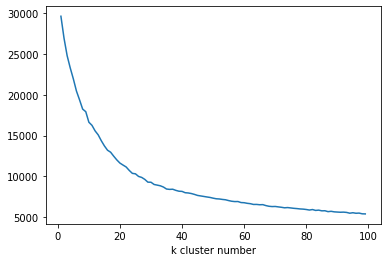

In [83]:
import matplotlib.pyplot as plt
inertias = []
ks = range(1,100)
for k in ks:
    km_test = KMeans(n_clusters=k).fit(X_proj)
    inertias.append(km_test.inertia_)
plt.plot(ks, inertias)
plt.xlabel('k cluster number')

### KNN after TfidVect

In [90]:
X_proj

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
DOOM,0.000000,0.146101,0.000000,0.275495,0.000000,0.000000,0.298439,0.307517,0.000000,0.000000,...,0.000000,0.309003,0.000000,0.214804,0.271478,0.000000,0.000000,0.0,0.0,0.000000
PLAYERUNKNOWN'S BATTLEGROUNDS,0.166751,0.090914,0.099813,0.000000,0.188685,0.000000,0.371418,0.191358,0.166751,0.000000,...,0.000000,0.384565,0.118124,0.000000,0.000000,0.000000,0.121855,0.0,0.0,0.000000
BATTLETECH,0.000000,0.115370,0.126663,0.000000,0.718326,0.000000,0.000000,0.242834,0.000000,0.000000,...,0.163709,0.000000,0.000000,0.169622,0.214375,0.237772,0.309269,0.0,0.0,0.000000
DayZ,0.234482,0.127841,0.140355,0.241064,0.000000,0.000000,0.261140,0.000000,0.234482,0.000000,...,0.000000,0.270383,0.166104,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.274902
EVE Online,0.000000,0.161674,0.000000,0.304861,0.000000,0.000000,0.000000,0.340296,0.000000,0.000000,...,0.229414,0.000000,0.210063,0.000000,0.000000,0.000000,0.216698,0.0,0.0,0.347655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Rocksmith® 2014 Edition – Remastered – Sabaton - “Ghost Division”,0.000000,0.000000,0.000000,0.000000,0.000000,0.652335,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.757931,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
Rocksmith® 2014 Edition – Remastered – Stone Temple Pilots - “Trippin’ on a Hole in a Paper Heart”,0.000000,0.000000,0.000000,0.000000,0.000000,0.652335,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.757931,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
Fantasy Grounds - Quests of Doom 4: A Midnight Council of Quail (5E),0.000000,0.000000,0.170242,0.000000,0.643644,0.000000,0.316746,0.000000,0.000000,0.322622,...,0.440066,0.000000,0.000000,0.000000,0.000000,0.000000,0.207837,0.0,0.0,0.000000
Mega Man X5 Sound Collection,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000


In [93]:
X_proj[3]

DOOM                                                                                                  0.275495
PLAYERUNKNOWN'S BATTLEGROUNDS                                                                         0.000000
BATTLETECH                                                                                            0.000000
DayZ                                                                                                  0.241064
EVE Online                                                                                            0.304861
                                                                                                        ...   
Rocksmith® 2014 Edition – Remastered – Sabaton - “Ghost Division”                                     0.000000
Rocksmith® 2014 Edition – Remastered – Stone Temple Pilots - “Trippin’ on a Hole in a Paper Heart”    0.000000
Fantasy Grounds - Quests of Doom 4: A Midnight Council of Quail (5E)                                  0.000000
M

In [94]:
from sklearn.neighbors import KNeighborsRegressor

# Define X and y
y = X_proj[3]

knn_model = KNeighborsRegressor().fit(X_proj,y) # Instanciate and train model

In [116]:
knn_model.kneighbors(X_proj.iloc[3500:3501],n_neighbors=10)

(array([[0.        , 0.45024594, 0.48443412, 0.51456511, 0.52393498,
         0.54099806, 0.57218194, 0.57218194, 0.57391338, 0.57391338]]),
 array([[ 3500, 21616, 21217, 25328, 15134, 15197,  4285, 16511, 15993,
          4847]]))

In [117]:
X_proj.iloc[[ 3500, 21616, 21217, 25328, 15134, 15197,  4285, 16511, 15993,
          4847], :]

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
Wild Romance: Mofu Mofu Edition,0.0,0.000000,0.329648,0.0,0.623160,0.335771,0.0,0.0,0.0,0.624709,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
Lost Labyrinth Extended Version,0.0,0.000000,0.296234,0.0,0.559996,0.301737,0.0,0.0,0.0,0.561388,...,0.382875,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
Sword Daughter,0.0,0.000000,0.524896,0.0,0.496127,0.267323,0.0,0.0,0.0,0.497360,...,0.000000,0.0,0.0,0.351458,0.0,0.0,0.000000,0.0,0.0,0.0
Tropia,0.0,0.260506,0.286006,0.0,0.540661,0.291319,0.0,0.0,0.0,0.542005,...,0.369655,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
Sephirothic Stories,0.0,0.000000,0.284402,0.0,0.537629,0.289685,0.0,0.0,0.0,0.538966,...,0.367582,0.0,0.0,0.000000,0.0,0.0,0.347207,0.0,0.0,0.0
Cursed Lands,0.0,0.000000,0.220276,0.0,0.416406,0.000000,0.0,0.0,0.0,0.834883,...,0.284701,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
Realms of Arkania: Star Trail,0.0,0.000000,0.310717,0.0,0.587373,0.000000,0.0,0.0,0.0,0.588833,...,0.401592,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
Tales of Maj'Eyal - Ashes of Urh'Rok,0.0,0.000000,0.310717,0.0,0.587373,0.000000,0.0,0.0,0.0,0.588833,...,0.401592,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
I Am Overburdened,0.0,0.000000,0.275359,0.0,0.520533,0.280473,0.0,0.0,0.0,0.521827,...,0.355893,0.0,0.0,0.368748,0.0,0.0,0.000000,0.0,0.0,0.0
ILLUSION,0.0,0.000000,0.275359,0.0,0.520533,0.280473,0.0,0.0,0.0,0.521827,...,0.355893,0.0,0.0,0.368748,0.0,0.0,0.000000,0.0,0.0,0.0


# Merging DB

In [48]:
reviews_df = pd.read_csv('../raw_data/reviews.csv')

In [53]:
merged_df = app_df.merge(reviews_df, on= 'url')

In [50]:
merged_df['languages'] = merged_df['languages'].fillna('English')

In [54]:
merged_df['clean_reviews']

KeyError: 'clean_reviews'